In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt

# Load Data

In [2]:
train_img = idx2numpy.convert_from_file('data/train-images.idx3-ubyte')
train_label = idx2numpy.convert_from_file('data/train-labels.idx1-ubyte')
test_img = idx2numpy.convert_from_file('data/t10k-images.idx3-ubyte')
test_label = idx2numpy.convert_from_file('data/t10k-labels.idx1-ubyte')

In [3]:
def load_data_of_digit(digit, imgs, lbs):
    idx = lbs==digit
    return imgs[idx]

In [4]:
train_img_1 = load_data_of_digit(1, train_img, train_label)
train_img_7 = load_data_of_digit(7, train_img, train_label)
test_img_1 = load_data_of_digit(1, test_img, test_label)
test_img_7 = load_data_of_digit(7, test_img, test_label)

In [5]:
from sklearn.decomposition import PCA

def build_PCA_dataset(d, tr_img_1, tr_img_7, ts_img_1, ts_img_7):
    tr_img_1 = tr_img_1.reshape(len(tr_img_1), -1)
    ts_img_1 = ts_img_1.reshape(len(ts_img_1), -1)
    tr_img_7 = tr_img_7.reshape(len(tr_img_7), -1)
    ts_img_7 = ts_img_7.reshape(len(ts_img_7), -1)

    imgs = np.concatenate([tr_img_1, tr_img_7]) #, ts_img_1, ts_img_7])
    pca = PCA(n_components=d)
    pca.fit(imgs)
    std = pca.transform(imgs).std(axis=0)
    # training set
    tr_pca_1 = pca.transform(tr_img_1) / std
    tr_pca_7 = pca.transform(tr_img_7) / std
    tr_lbs_1 = np.ones([len(tr_pca_1), 1])
    tr_lbs_7 = -np.ones([len(tr_pca_7), 1])
    #test set
    ts_pca_1 = pca.transform(ts_img_1) / std
    ts_pca_7 = pca.transform(ts_img_7) / std
    ts_lbs_1 = np.ones([len(ts_pca_1), 1])
    ts_lbs_7 = -np.ones([len(ts_pca_7), 1])
    return np.concatenate([tr_pca_1, tr_pca_7]), np.concatenate([tr_lbs_1, tr_lbs_7]), \
        np.concatenate([ts_pca_1, ts_pca_7]), np.concatenate([ts_lbs_1, ts_lbs_7])

# Model

In [6]:
class QuadraticModel:
    def __init__(self, dim):
        self.dim = dim
        self.w = np.random.randn(dim**2 + dim + 1, 1)
    
    @property
    def W(self):
        return self.w[:self.dim**2].reshape(self.dim, self.dim)
    
    @property
    def v(self):
        return self.w[self.dim**2:-1] #20x1
    
    @property
    def b(self):
        return self.w[-1:] #1x1

    def __call__(self, X):
        return np.reshape(np.sum(X * (X @ self.W), axis=-1, keepdims=True) + X @ self.v + self.b, [-1, 1]) 
    
    def q(self, X, y):
        return y * self(X)

    def _w(self, X):
        X1 = np.expand_dims(X, 1)
        X2 = np.expand_dims(X, -1)
        dW, dv, db = X1 * X2, X[..., np.newaxis], np.ones([len(X), 1, 1])
        return np.concatenate([dW.reshape(len(X), -1), dv.reshape(len(X), -1), db.reshape(len(X), -1)], axis=-1)[..., np.newaxis]

# Loss

In [7]:
class Loss:
    def __init__(self, data, label, batch_size=None, lam=1e-3):
        self.data = data
        self.label = label
        self.n = batch_size
        self.lam = lam
        self.last_sample = self.sample_batch()
        
    def __call__(self, model, use_last_sample=False):
        if use_last_sample:
            X, y = self.last_sample
        else:
            X, y = self.sample_batch()
            self.last_sample = X, y
        q = model.q(X, y)
        L = np.mean(np.log(1 + np.exp(-q))) + 0.5 * self.lam * (np.sum(model.w ** 2))
        L_w = self._w(model, X, y)
        return L, L_w
    
    def _w(self, model, X, y):
        q = model.q(X, y) # bx1
        coef = - y * np.exp(-q) / (1 + np.exp(-q)) # bx1
        f_w = model._w(X) # bxdxd, bxdx1, bx1x1
        d_w = np.mean(coef[..., np.newaxis] * f_w, axis=0) + self.lam * model.w
        return d_w
    
    def sample_batch(self):
        if self.n:
            idx = np.random.choice(len(self.data), self.n, replace=False)
            X = self.data[idx]
            y = self.label[idx]
            return X, y
        else:
            return self.data, self.label

# Optimizers

In [8]:
from copy import deepcopy

class _Optimizer:
    def __init__(self, model, alpha, silent=True):
        self.model = model
        self.alpha = alpha
        self.silent = silent

    @property
    def parameters(self):
        return self.model.w


class SGD(_Optimizer):    
    def __call__(self, loss):
        f, g = loss(self.model)
        self.parameters[...] = self.parameters - self.alpha * g
        if not self.silent: return f, g
    
    def __str__(self) -> str: return 'SGD'


class Nesterov(_Optimizer):
    def __init__(self, model, alpha, silent=True):
        super().__init__(model, alpha, silent)
        self.k = 0
        self.x = np.copy(self.parameters)
        
    def __call__(self, loss):
        f, g = loss(self.model)
        x_ = self.parameters - self.alpha * g
        self.parameters[...] = (1 + self.mu) * x_ - self.mu * self.x
        self.x = x_
        if not self.silent: return f, g 

    @property
    def mu(self):
        return 1 - 3 / (5 + self.k)
    
    def __str__(self) -> str: return 'Nesterov'


class Adam(_Optimizer):
    def __init__(self, model, alpha, beta_1=0.9, beta_2=0.999, epsilon=1e-8, silent=True):
        super().__init__(model, alpha, silent)
        self.beta_1, self.beta_2 = beta_1, beta_2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.k = 0
    
    def __call__(self, loss):
        self.k += 1
        f, g = loss(self.model)
        self.m = self.beta_1 * self.m + (1-self.beta_1) * g
        self.v = self.beta_2 * self.v + (1-self.beta_2) * (g ** 2)
        m_hat = self.m / (1 - self.beta_1 ** self.k)
        v_hat = self.v / (1 - self.beta_2 ** self.k)
        self.parameters[...] = self.parameters - self.alpha * m_hat / (np.sqrt(v_hat) + self.epsilon)
        if not self.silent: return f, g
    
    def __str__(self) -> str: return 'Adam'

class LBFGS(_Optimizer):
    def __init__(self, model, alpha, m=5, M=20, silent=True):
        super().__init__(model, alpha, silent)
        self.k = 0
        self.m = m
        self.M = M
        self.s = []
        self.y = []
        self.alpha = 1e-3 # overwrite
    
    def __call__(self, loss):
        f, g = loss(self.model)
        if self.s and self.y:
            q = g; a = []
            for s, y in zip(reversed(self.s), reversed(self.y)):
                rho = 1 / (y.T @ s)
                a.append(rho * s.T @ q)
                q = q - a[-1] * y
            gamma = (self.s[-1].T @ self.y[-1]) \
                    / (self.y[-1].T @ self.y[-1])
            H = np.eye(len(g)) * gamma
            z = H @ q
            for s, y, a in zip(self.s, self.y, a):
                rho = 1 / (y.T @ s)
                beta = rho * y.T @ z
                z = z + (a - beta) * s
            p = -z
        else:
            p = -g

        old_model = deepcopy(self.model)
        self.parameters[...] = self.parameters + self.alpha * p
        
        if self.k % self.M == 0: 
            self._update_sy(old_model, loss)
        self.k += 1
        
        if not self.silent: return f, g
    
    def _update_sy(self, old_model, loss):
        self.s.append(self.parameters - old_model.w)
        if len(self.s) > self.m: self.s.pop(0)
        _, g_old = loss(old_model)
        _, g = loss(self.model, use_last_sample=True) 
        self.y.append(g - g_old)
        if len(self.y) > self.m: self.y.pop(0)

    def __str__(self) -> str: return 'LBFGS'

# Training

In [9]:
def accuracy(model, X, y, class_idx):
    '''return total accuracy and accuracies for each class'''
    pred = model.q(X, y)
    return np.sum(pred > 0), np.sum(pred[:class_idx] > 0), np.sum(pred[class_idx:] > 0)

In [10]:
from copy import deepcopy
from tqdm import tqdm

d = 20

train_X, train_y, test_X, test_y = build_PCA_dataset(d, train_img_1, train_img_7, test_img_1, test_img_7)
model_ = QuadraticModel(d)

alpha = 1e-2
epochs = 1000 #10000

optimizers = (SGD, Nesterov, Adam, LBFGS)
batch_sizes = [16, 32, 64, 128]

batch_list = []
for batch in batch_sizes:
    opt_list = []
    print('Batch size = {}'.format(batch))
    for optimizer in optimizers:
        model = deepcopy(model_)
        opt = optimizer(model, alpha, silent=False)
        loss = Loss(train_X, train_y, batch, lam=1e-3)
        
        f_list = np.empty(epochs)
        g_list = np.empty(epochs)

        for i in tqdm(range(epochs), desc='\tTraining with {}'.format(opt, batch)):
            f, g = opt(loss)
            f_list[i] = f
            g_list[i] = np.linalg.norm(g)
        opt_list.append([model, f_list, g_list, accuracy(model, train_X, train_y, len(train_img_1)), accuracy(model, test_X, test_y, len(test_img_1))])
    batch_list.append(opt_list)

Batch size = 16


	Training with LBFGS:  34%|███▎      | 336/1000 [00:00<00:01, 572.52it/s]C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\3428210156.py:16: RuntimeWarning: overflow encountered in exp
  L = np.mean(np.log(1 + np.exp(-q))) + 0.5 * self.lam * (np.sum(model.w ** 2))
C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\3428210156.py:22: RuntimeWarning: overflow encountered in exp
  coef = - y * np.exp(-q) / (1 + np.exp(-q)) # bx1
C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\3428210156.py:22: RuntimeWarning: invalid value encountered in true_divide
  coef = - y * np.exp(-q) / (1 + np.exp(-q)) # bx1
	Training with LBFGS: 100%|██████████| 1000/1000 [00:01<00:00, 615.22it/s]


Batch size = 32


	Training with LBFGS: 100%|██████████| 1000/1000 [00:01<00:00, 634.28it/s]


Batch size = 64


	Training with LBFGS: 100%|██████████| 1000/1000 [00:01<00:00, 638.78it/s]


Batch size = 128


	Training with LBFGS: 100%|██████████| 1000/1000 [00:01<00:00, 594.25it/s]


In [11]:
def plot_lvalue(ax, l_list):
    ax.plot(np.arange(len(l_list)), l_list)
    ax.set_xlabel('k')
    ax.set_ylabel('L(w)')

def plot_gnorm(ax, g_list):
    ax.plot(np.arange(len(g_list)), g_list)
    ax.set_xlabel('k')
    ax.set_ylabel(r'$\|\nabla L(w)\|$')

def plot_confusion_matrix(ax, accuracy_tuple, n_sample=(1135, 1028)):
    m = np.empty([2, 2])
    m[0, 0] = accuracy_tuple[1]
    m[0, 1] = n_sample[0] - m[0, 0]
    m[1, 1] = accuracy_tuple[2]
    m[1, 0] = n_sample[1] - m[1, 1]
    ax.matshow(m)
    for (i, j), z in np.ndenumerate(m):
        ax.text(j, i, '{}'.format(int(z)), ha='center', va='center', color='grey', fontsize=30)
    ax.set_ylabel('True Label')
    ax.set_yticklabels(['0', '1', '7'])
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['0', '1', '7'])
    ax.xaxis.set_tick_params(labelbottom=True, labeltop=False)
    ax.set_title('#correct={}, #wrong={}'.format(accuracy_tuple[0], np.sum(n_sample)-accuracy_tuple[0]))

def plot_plane(ax, model, set1, set7):
    ax.scatter(set1[:, 0], set1[:, 1], set1[:, 2], s=1, alpha=0.3, label='1')
    ax.scatter(set7[:, 0], set7[:, 1], set7[:, 2], s=1, alpha=0.3, label='7')
    # xx, yy = np.meshgrid(np.linspace(-10, -2, 2), np.linspace(-4, 4, 2))
    # zz = model(xx, yy) #(w[0]*xx + w[1]*yy + w[3]) / (-w[2])
    # ax.plot_surface(xx, yy, zz, color='green', alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend(loc=9, ncol=2)
    lgnd = ax.get_legend()
    lgnd.legendHandles[0]._linewidths = np.array([5.])
    lgnd.legendHandles[0]._alpha = 1.
    lgnd.legendHandles[1]._linewidths = np.array([5.])
    lgnd.legendHandles[1]._alpha = 1.
    # ax.view_init(30, 180)

def plot_gd(opt_list, title=None):
    fig, axes = plt.subplots(len(optimizers), 3, figsize=(3*4, 4*len(optimizers))) 
    # for i in range(len(optimizers)): axes[i, -1] = plt.subplot(len(optimizers), 4, 4*(i+1), projection='3d')
    for i, (bl, bz) in enumerate(zip(opt_list, optimizers)):
        model, f_list, g_list, acc_train, acc_test = bl
        plot_lvalue(axes[i, 0], f_list)
        plot_gnorm(axes[i, 1], g_list)
        plot_confusion_matrix(axes[i, 2], acc_test)
        # plot_plane(axes[i, 3], model, train_X[:len(train_img_1)], train_X[len(train_img_1):])

    axes[0, 0].set_title('$L(w)$ History')
    axes[0, 1].set_title(r'$\|\nabla L\|$ History')
    for i, Opt in enumerate(optimizers): axes[i, 0].set_ylabel('{}'.format(Opt(model, alpha)))
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.show()

C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\2860745146.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '1', '7'])
C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\2860745146.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '1', '7'])
C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\2860745146.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


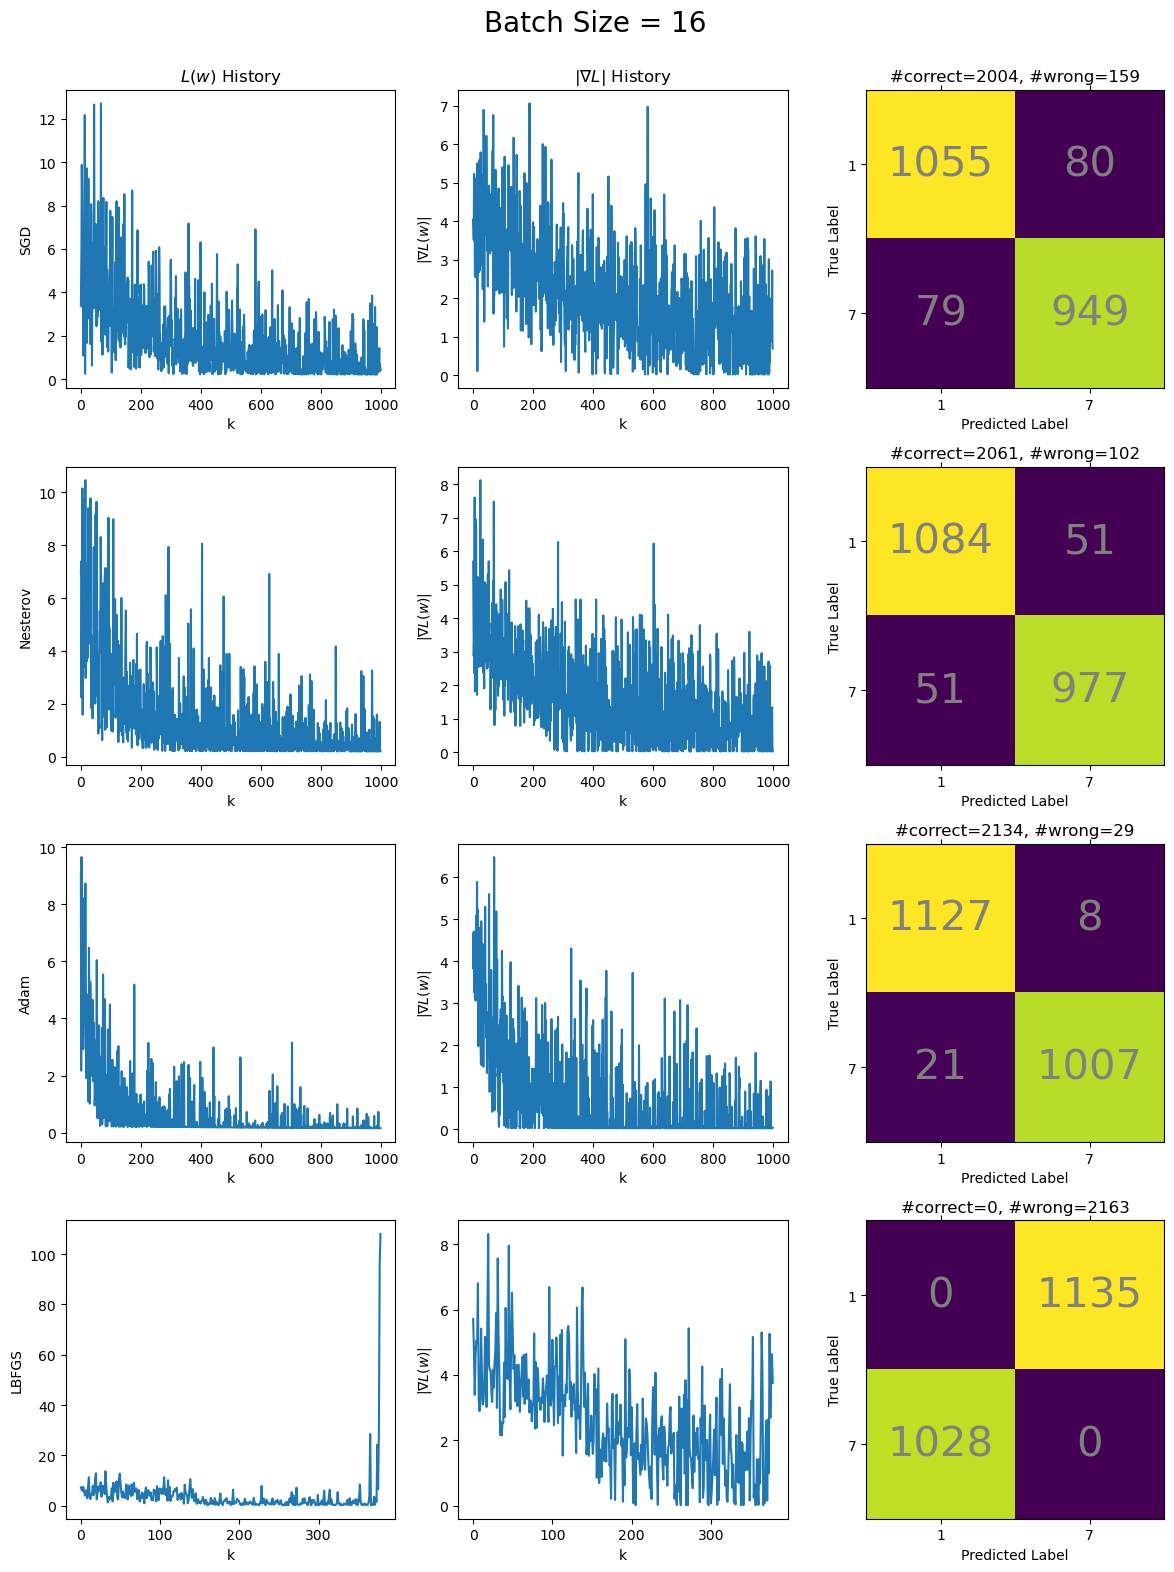

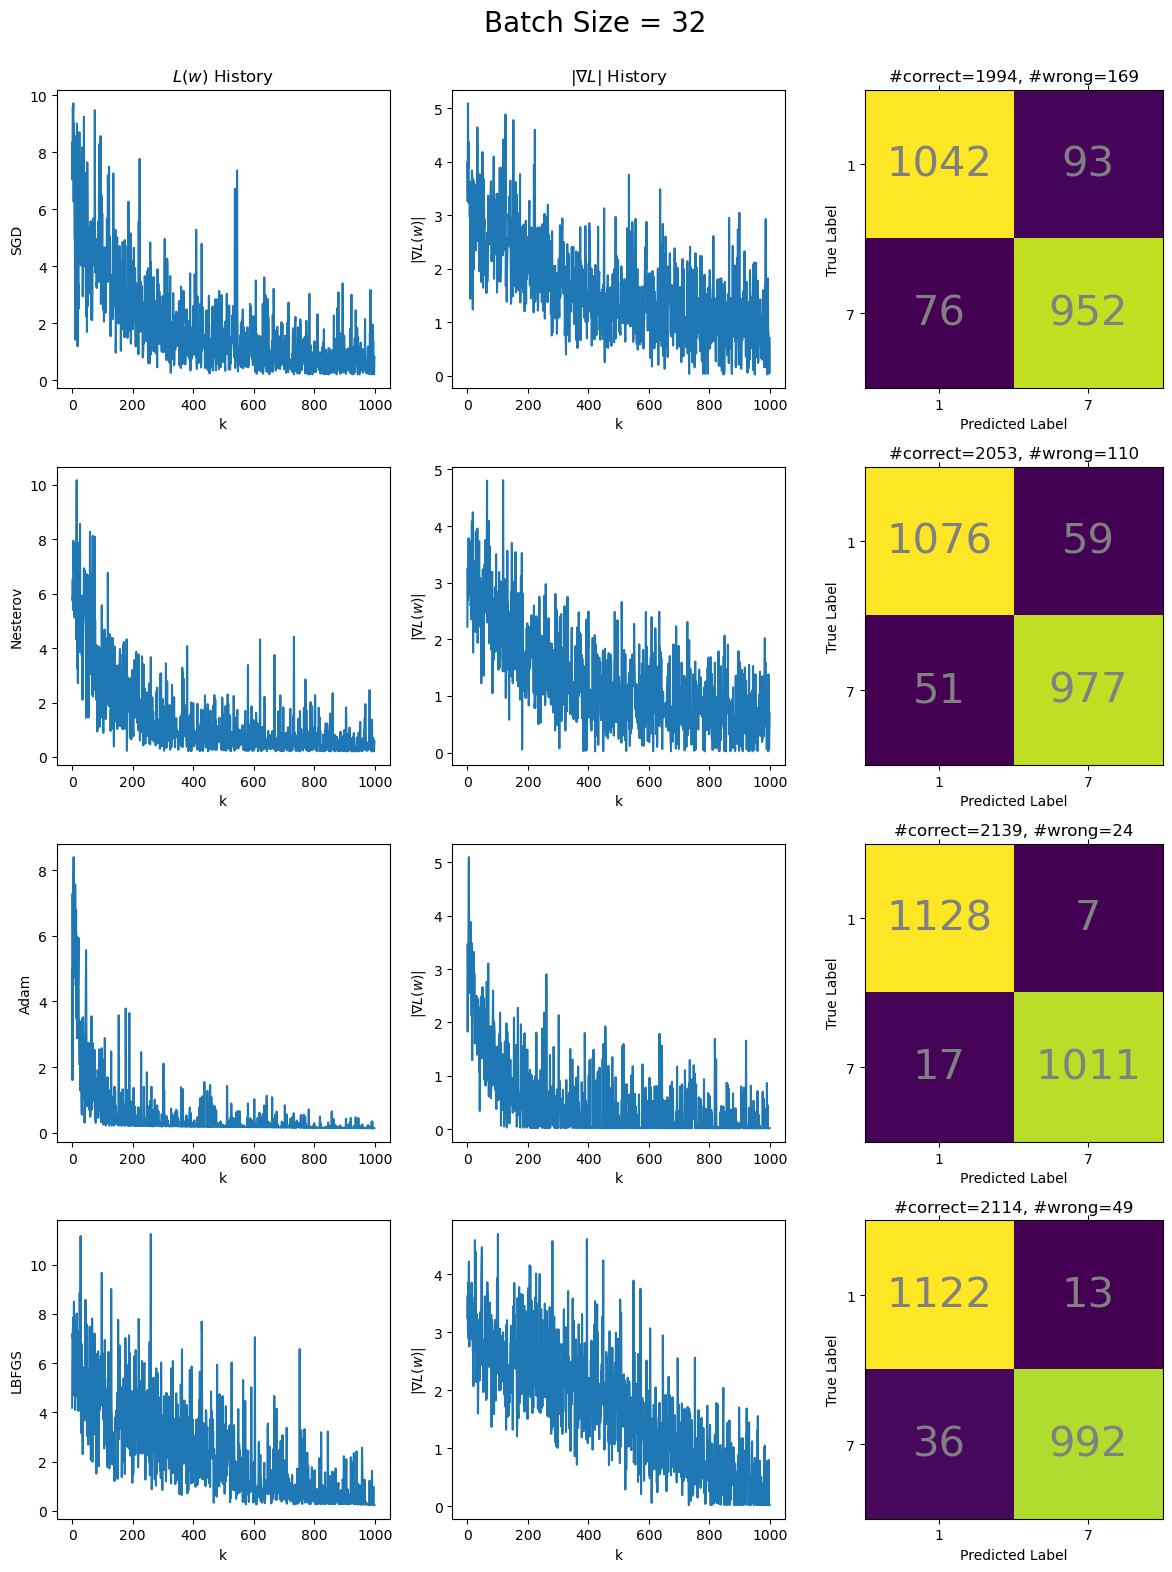

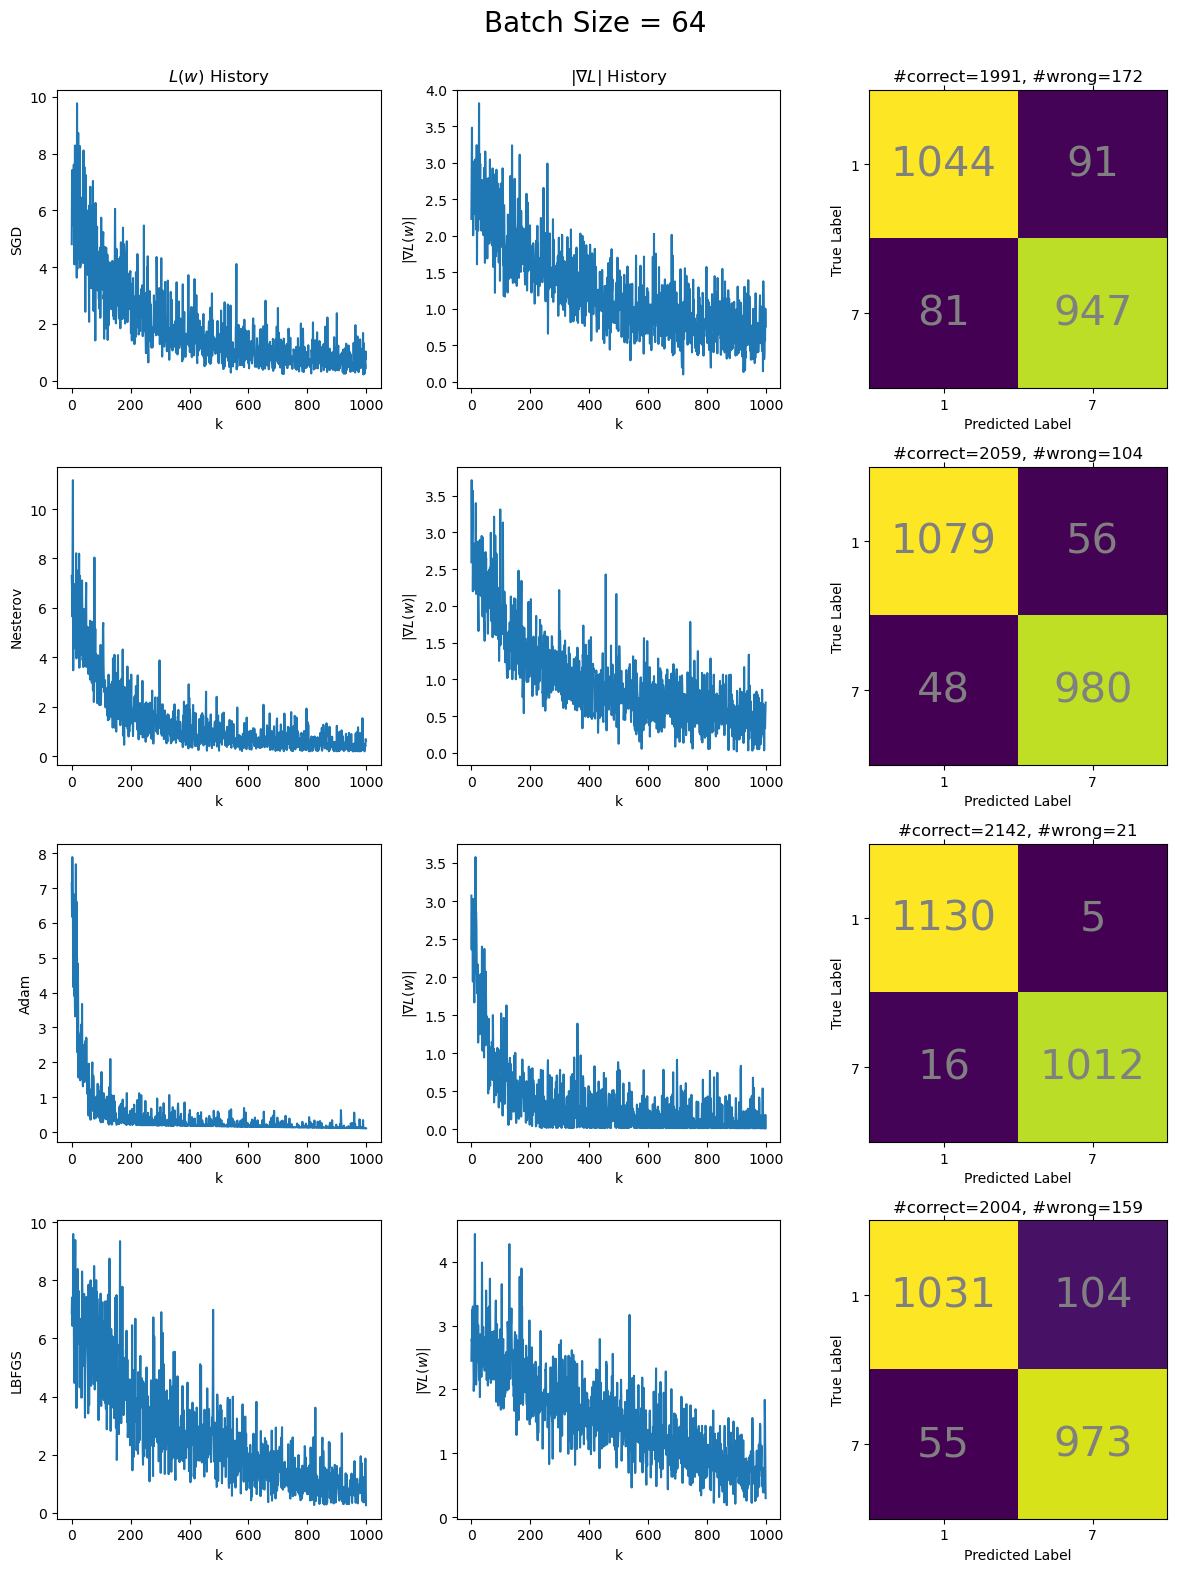

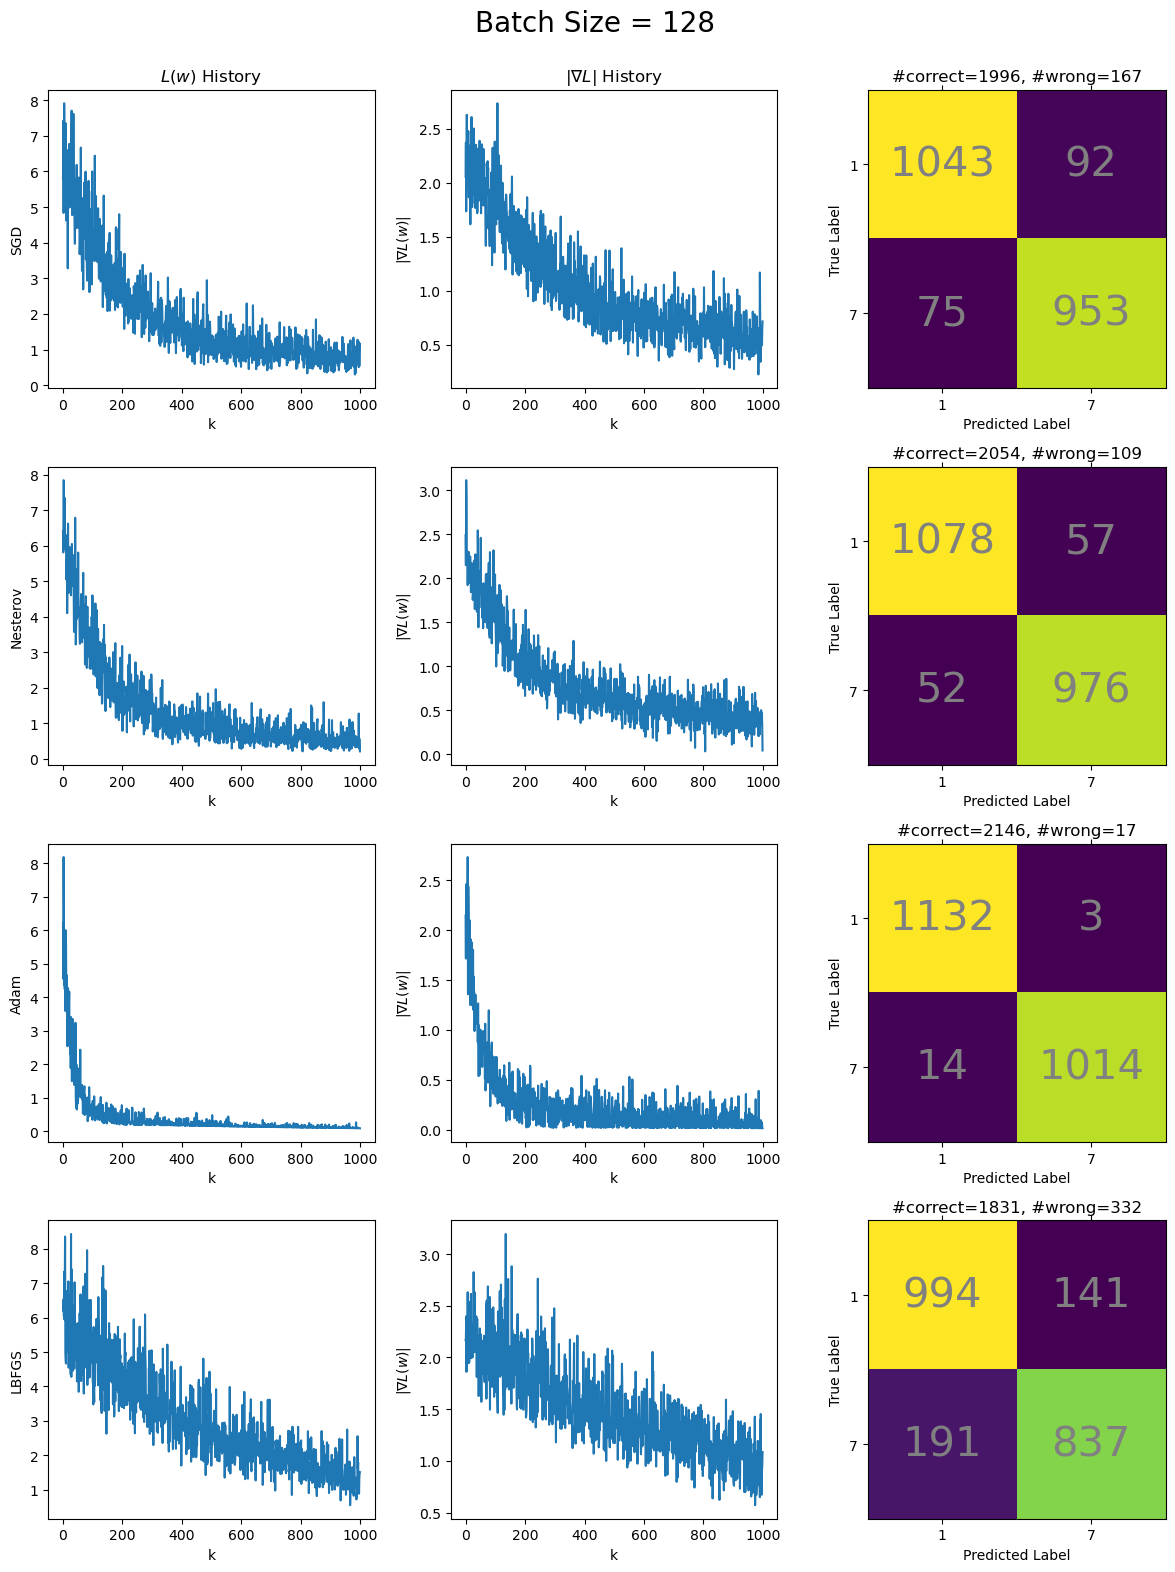

In [12]:
for blist, bsz in zip(batch_list, batch_sizes):
    plot_gd(blist, 'Batch Size = {}\n'.format(bsz))

Comment: Adam seems to be the most efficient one. LBFGS has the trend of driving the value of q to infinity, especially when the batch size is small.

# Experiment with Adam on different number of components

In [13]:
alpha = 1e-2
epochs = 1000
batch = 32
ds = [3, 5, 10, 20, 50]

d_list = []
for d in ds:
    train_X, train_y, test_X, test_y = build_PCA_dataset(d, train_img_1, train_img_7, test_img_1, test_img_7)
    model = QuadraticModel(d)
    opt = Adam(model, alpha, silent=False)
    loss = Loss(train_X, train_y, batch, lam=1e-3)
    
    f_list = np.empty(epochs)
    g_list = np.empty(epochs)

    for i in tqdm(range(epochs), desc='\tTraining with {} for d = {}'.format(opt, d)):
        f, g = opt(loss)
        f_list[i] = f
        g_list[i] = np.linalg.norm(g)
    d_list.append([model, f_list, g_list, accuracy(model, train_X, train_y, len(train_img_1)), accuracy(model, test_X, test_y, len(test_img_1))])

	Training with Adam for d = 50: 100%|██████████| 1000/1000 [00:00<00:00, 1186.01it/s]


In [15]:
def plot_pca(d_list, title=None):
    fig, axes = plt.subplots(len(ds), 3, figsize=(3*4, 4*len(ds))) 
    for i, (bl, bz) in enumerate(zip(d_list, ds)):
        model, f_list, g_list, acc_train, acc_test = bl
        plot_lvalue(axes[i, 0], f_list)
        plot_gnorm(axes[i, 1], g_list)
        plot_confusion_matrix(axes[i, 2], acc_test)

    axes[0, 0].set_title('$L(w)$ History')
    axes[0, 1].set_title(r'$\|\nabla L\|$ History')
    for i, d in enumerate(ds): axes[i, 0].set_ylabel('d = {}'.format(d))
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.show()

C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\2860745146.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '1', '7'])
C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\2860745146.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '1', '7'])
C:\Users\geniu\AppData\Local\Temp\ipykernel_429532\318363419.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


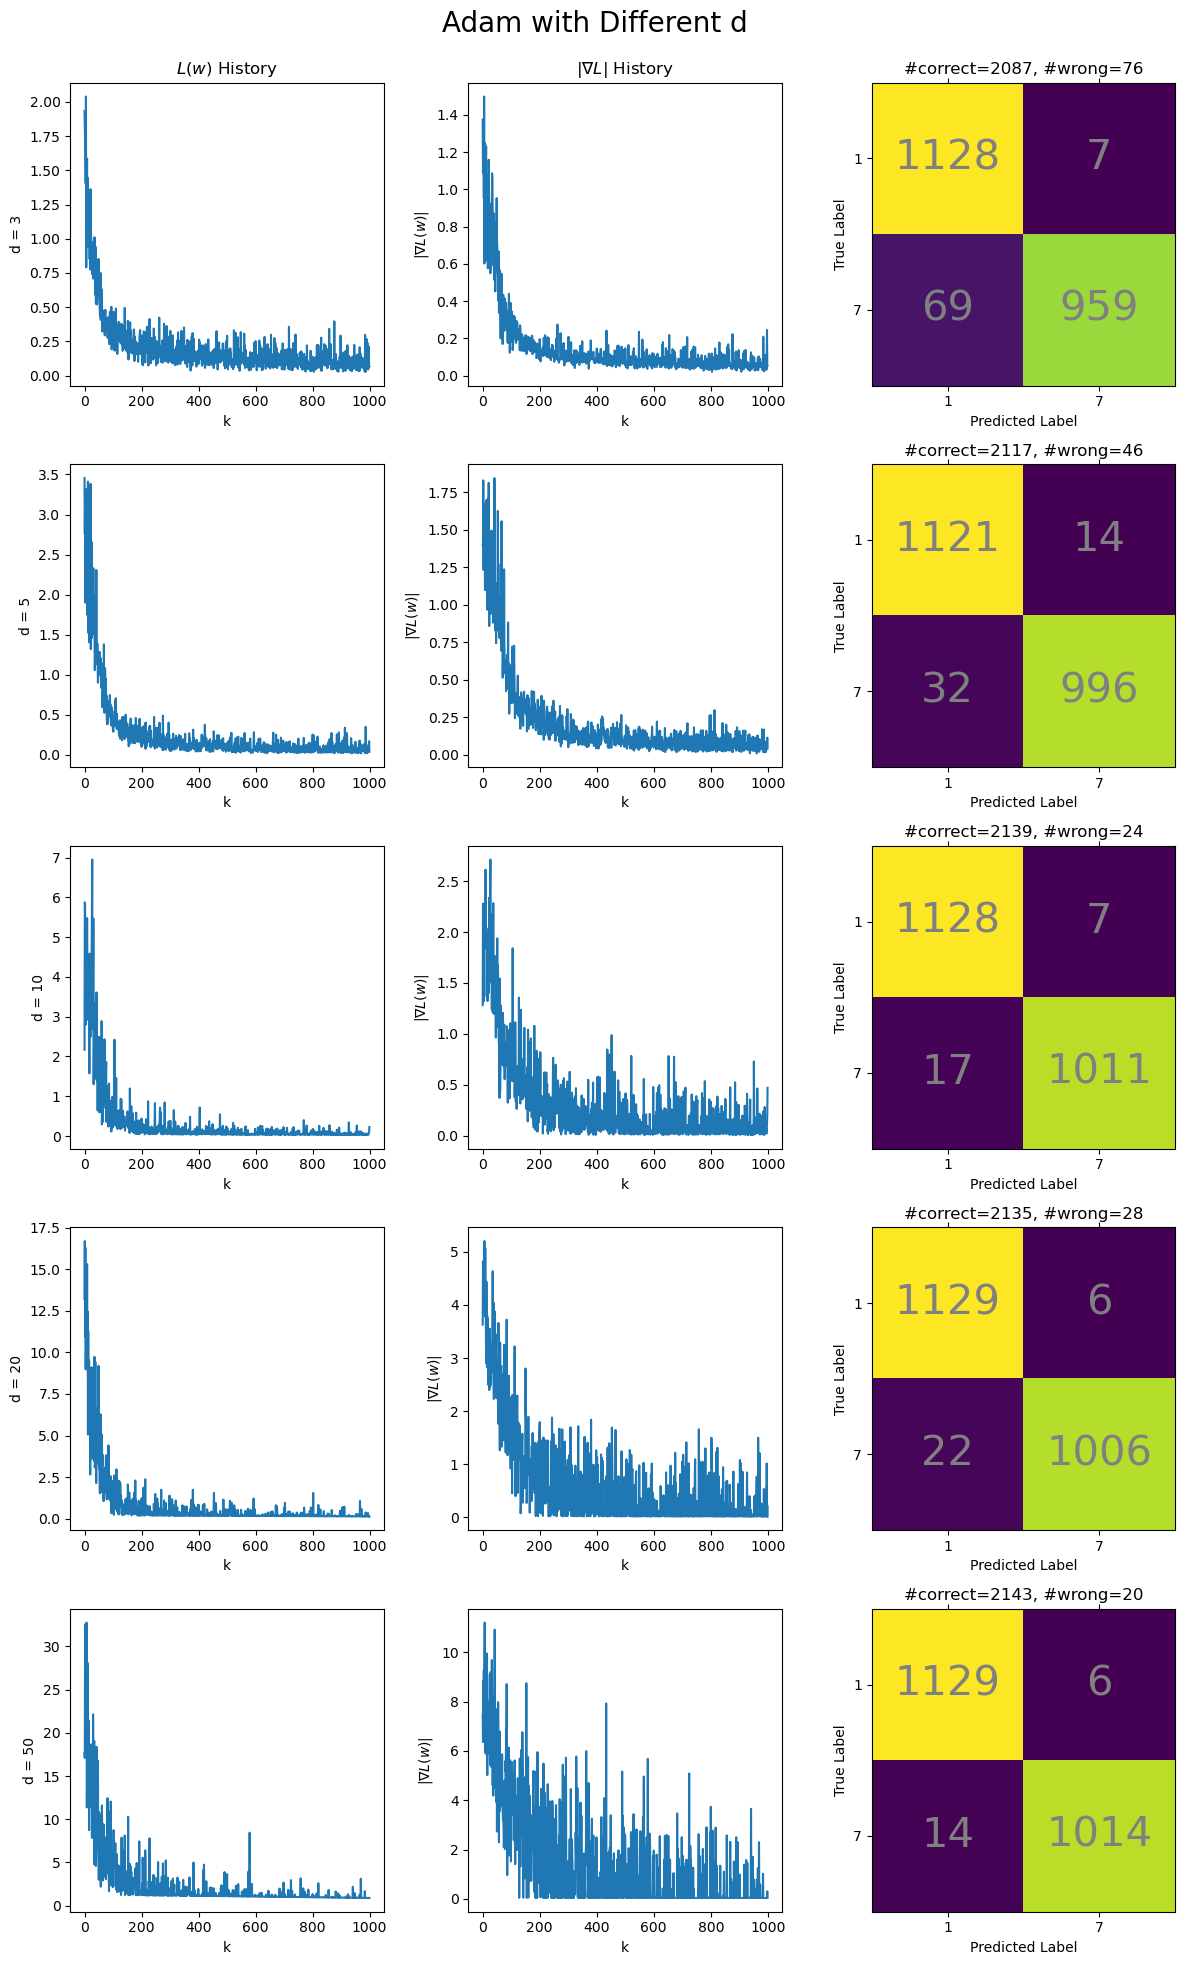

In [17]:
plot_pca(d_list, title='Adam with Different d\n')